In [ ]:
!pip install vaderSentiment


In [ ]:
!pip install contractions

In [ ]:
!pip install pyspellchecker

In [ ]:
import pandas as pd
import re
import nltk
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import pickle
import contractions

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from wordcloud import WordCloud
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from spellchecker import SpellChecker



In [ ]:
# Unduh resource NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Load data
df = pd.read_csv('blue_yungkai_mv.csv')
df = df.dropna(subset=['text']).drop_duplicates(subset='text')

print(f"Jumlah baris (data): {df.shape[0]}")

Jumlah baris (data): 19171


In [ ]:
# Inisialisasi
lemmatizer = WordNetLemmatizer()
spell = SpellChecker()

# Stopwords dan pengecualian
stop_words = set(stopwords.words('english'))

negation_words = [
    "no", "not", "nor", "neither", "never", "nothing", "nowhere", "hardly",
    "barely", "doesn't", "isn't", "wasn't", "shouldn't", "wouldn't",
    "couldn't", "won't", "can't", "don't", "didn't", "hasn't", "haven't", "hadn't"
]

intensifier_words = [
    "very", "really", "so", "too", "quite", "such", "absolutely", "extremely",
    "totally", "completely", "highly"
]

diminisher_words = [
    "just", "only", "somewhat", "fairly", "slightly", "barely", "hardly"
]

contrast_words = [
    "but", "however", "although", "though", "yet", "even though", "still"
]

important_stopwords = set(
    negation_words + intensifier_words + diminisher_words + contrast_words
)

# Buat custom stopwords tanpa kata penting
custom_stopwords = stop_words - important_stopwords

# Mapping POS ke WordNet
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Slang word dictionary
slang_word = {
    "u": "you", "r": "are", "ur": "your", "btw": "by the way",
    "idk": "i do not know", "lol": "laughing out loud", "omg": "oh my god",
    "lmao": "laughing my ass off", "rofl": "rolling on the floor laughing",
    "brb": "be right back", "gtg": "got to go", "imo": "in my opinion",
    "imho": "in my humble opinion", "fyi": "for your information",
    "tbh": "to be honest", "smh": "shaking my head", "np": "no problem",
    "jk": "just kidding", "nvm": "never mind", "bff": "best friend forever",
    "dm": "direct message", "tldr": "too long did not read", "wth": "what the heck",
    "af": "as f*", "ikr": "i know right", "ya": "yeah", "thx": "thanks",
    "ty": "thank you", "plz": "please", "bc": "because", "cuz": "because",
    "tho": "though", "k": "okay", "ok": "okay", "hbu": "how about you",
    "wyd": "what are you doing", "wbu": "what about you", "rn": "right now",
    "bday": "birthday", "gr8": "great", "luv": "love", "xoxo": "hugs and kisses",
    "yall": "you all"
}

# Cleaning emojis, simbol, dan noise
def cleaningText(text):
    emoji_pattern = re.compile(
        "[" u"\U0001F600-\U0001F64F" u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF" u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF" u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251" "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', str(text))
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    return text

# Case folding
def casefoldingText(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Expand contractions
def expandContractions(text):
    return contractions.fix(text)

# Standarisasi slang
def standard_slangwords(text):
    words = text.split()
    return " ".join([slang_word.get(w, w) for w in words])

# Tokenisasi
def tokenizingText(text):
    return word_tokenize(text)

# Stopword removal dengan pengecualian
def filteringText(tokens):
    return [word for word in tokens if word not in custom_stopwords]

# Lemmatization
def lemmatizationText(tokens):
    pos_tags = pos_tag(tokens)
    return [lemmatizer.lemmatize(w, get_wordnet_pos(t)) for w, t in pos_tags]

# Validasi teks kosong
def is_valid_text(tokens):
    return len(tokens) > 2

# Pipeline akhir
def preprocess_pipeline(text):
    text = cleaningText(text)
    text = casefoldingText(text)
    text = expandContractions(text)
    text = standard_slangwords(text)
    tokens = tokenizingText(text)
    tokens = filteringText(tokens)
    tokens = lemmatizationText(tokens)
    return tokens if is_valid_text(tokens) else []

In [ ]:
# Salin dataframe
clean_df = df.copy()

# Langkah-langkah preprocessing sesuai urutan pipeline
clean_df['text_clean'] = clean_df['text'].apply(cleaningText)
clean_df['text_casefolding'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_expanded'] = clean_df['text_casefolding'].apply(expandContractions)
clean_df['text_slang'] = clean_df['text_expanded'].apply(standard_slangwords)
clean_df['tokens'] = clean_df['text_slang'].apply(tokenizingText)
clean_df['tokens_filtered'] = clean_df['tokens'].apply(filteringText)
clean_df['lemmatized'] = clean_df['tokens_filtered'].apply(lemmatizationText)

# Validasi minimal panjang token (≥3 kata agar tidak terlalu singkat)
clean_df = clean_df[clean_df['lemmatized'].apply(lambda x: len(x) > 2)].copy()

# Gabungkan token jadi teks akhir
clean_df['text_akhir'] = clean_df['lemmatized'].apply(lambda x: " ".join(x))
clean_df['text_akhir'] = clean_df['text_akhir'].astype('str')
clean_df['text_akhir'] = clean_df['text_akhir'].astype(pd.StringDtype())

# Simpan ke CSV
clean_df.to_csv("blue_yungkai_mv_clean.csv", index=False)
print("Preprocessing berhasil dilakukan dan disimpan ke 'blue_yungkai_mv_clean.csv'.")

# Tampilkan hasil
clean_df[['text', 'text_akhir']].head()

Preprocessing berhasil dilakukan dan disimpan ke 'blue_yungkai_mv_clean.csv'.


,text,text_akhir
0,thank you everyone i love you <3,thank everyone love
7,cant understand shit,not understand shit
9,May 1st! Starting new month with a masterpiece,may st start new month masterpiece
10,"till now i learned a lesson ""that every thing ...",till learn lesson every thing not end good end
11,soft spoken person's anthem..,soft spoken person anthem


In [ ]:
# Atur agar seluruh isi sel tampil (tidak dipotong)
pd.set_option('display.max_colwidth', None)  # agar konten kolom panjang terlihat semua
pd.set_option('display.max_columns', None)   # agar semua kolom terlihat
pd.set_option('display.expand_frame_repr', False)  # agar tampilan tidak dibungkus

In [ ]:
clean_df.head()

,text,text_clean,text_casefolding,text_expanded,text_slang,tokens,tokens_filtered,lemmatized,text_akhir
0,thank you everyone i love you <3,thank you everyone i love you,thank you everyone i love you,thank you everyone i love you,thank you everyone i love you,"[thank, you, everyone, i, love, you]","[thank, everyone, love]","[thank, everyone, love]",thank everyone love
7,cant understand shit,cant understand shit,cant understand shit,cannot understand shit,cannot understand shit,"[can, not, understand, shit]","[not, understand, shit]","[not, understand, shit]",not understand shit
9,May 1st! Starting new month with a masterpiece,May st Starting new month with a masterpiece,may st starting new month with a masterpiece,may st starting new month with a masterpiece,may st starting new month with a masterpiece,"[may, st, starting, new, month, with, a, masterpiece]","[may, st, starting, new, month, masterpiece]","[may, st, start, new, month, masterpiece]",may st start new month masterpiece
10,"till now i learned a lesson ""that every thing doesnt end with a good ending""",till now i learned a lesson that every thing doesnt end with a good ending,till now i learned a lesson that every thing doesnt end with a good ending,till now i learned a lesson that every thing does not end with a good ending,till now i learned a lesson that every thing does not end with a good ending,"[till, now, i, learned, a, lesson, that, every, thing, does, not, end, with, a, good, ending]","[till, learned, lesson, every, thing, not, end, good, ending]","[till, learn, lesson, every, thing, not, end, good, end]",till learn lesson every thing not end good end
11,soft spoken person's anthem..,soft spoken persons anthem,soft spoken persons anthem,soft spoken persons anthem,soft spoken persons anthem,"[soft, spoken, persons, anthem]","[soft, spoken, persons, anthem]","[soft, spoken, person, anthem]",soft spoken person anthem


In [ ]:
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_columns')
pd.reset_option('display.expand_frame_repr')

In [ ]:
# Inisialisasi analyzer
analyzer = SentimentIntensityAnalyzer()

# Fungsi untuk analisis sentimen
def vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Terapkan fungsi pada kolom komentar
clean_df['sentiment_vader'] = clean_df['text_akhir'].apply(vader_sentiment)

# Simpan hasilnya ke CSV
clean_df.to_csv("blue_yungkai_mv_clean.csv", index=False)
print("Analisis sentimen selesai dan disimpan ke 'blue_yungkai_mv_clean.csv'.")

# Tampilkan contoh hasil
clean_df[['text', 'text_akhir', 'sentiment_vader']].head(20)


Analisis sentimen selesai dan disimpan ke 'blue_yungkai_mv_clean.csv'.


,text,text_akhir,sentiment_vader
0,thank you everyone i love you <3,thank everyone love,positive
7,cant understand shit,not understand shit,positive
9,May 1st! Starting new month with a masterpiece,may st start new month masterpiece,positive
10,"till now i learned a lesson ""that every thing ...",till learn lesson every thing not end good end,negative
11,soft spoken person's anthem..,soft spoken person anthem,neutral
12,Who's listening 1st May 2025?,listen st may,neutral
14,"If yall like this song like me, YAL WILL DEFIN...",like song like yal definitely like cotrust,positive
17,i'll imagine we fell in love - i have already ...,ill imagine fell love already fall,positive
19,Who is hearing this masterpiece in May 2025?,hear masterpiece may,positive
22,@@ykaizzk can i borrow this for a bigbrain cov...,borrow bigbrain cover trilingual version tagli...,neutral


/tmp/ipython-input-36-1394573034.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_counts, x='Sentiment', y='Count', palette='viridis')


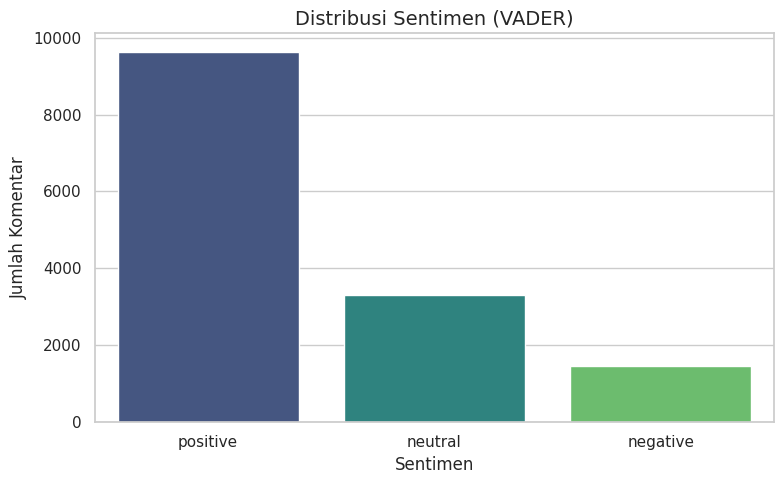

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style visual
sns.set(style="whitegrid")

# Hitung distribusi sentimen
sentiment_counts = clean_df['sentiment_vader'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']

# Bar chart
plt.figure(figsize=(8,5))
sns.barplot(data=sentiment_counts, x='Sentiment', y='Count', palette='viridis')
plt.title('Distribusi Sentimen (VADER)', fontsize=14)
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Komentar')
plt.tight_layout()
plt.show()


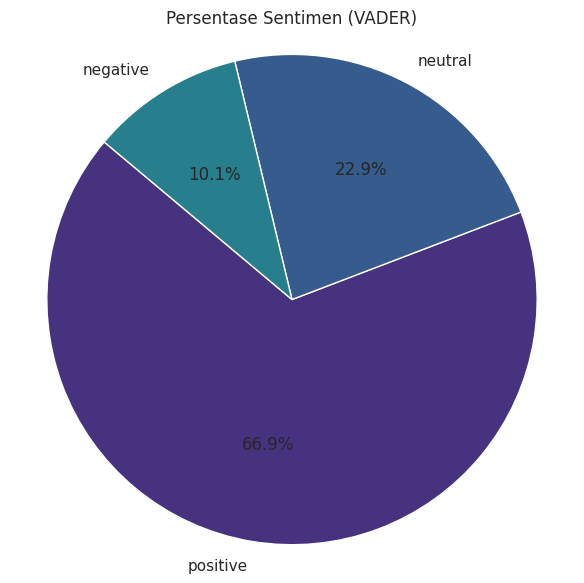

In [ ]:
# Pie chart
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts['Count'], labels=sentiment_counts['Sentiment'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'))
plt.title('Persentase Sentimen (VADER)')
plt.axis('equal')
plt.tight_layout()
plt.show()


📈 Sentimen Positif


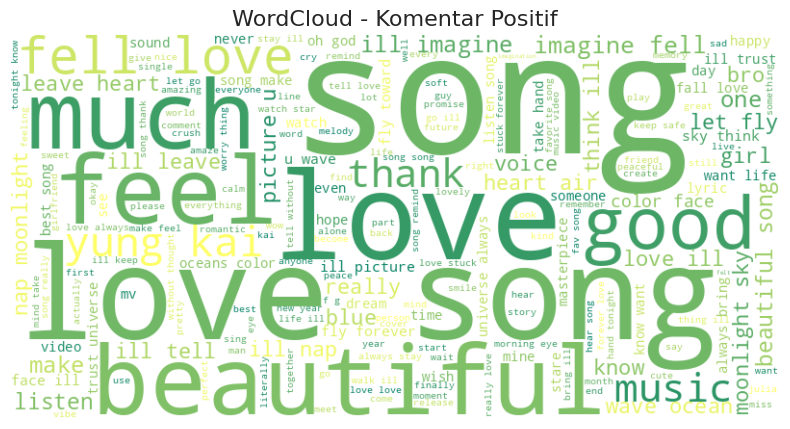

/tmp/ipython-input-38-3546788219.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(top_words), palette=color_map)


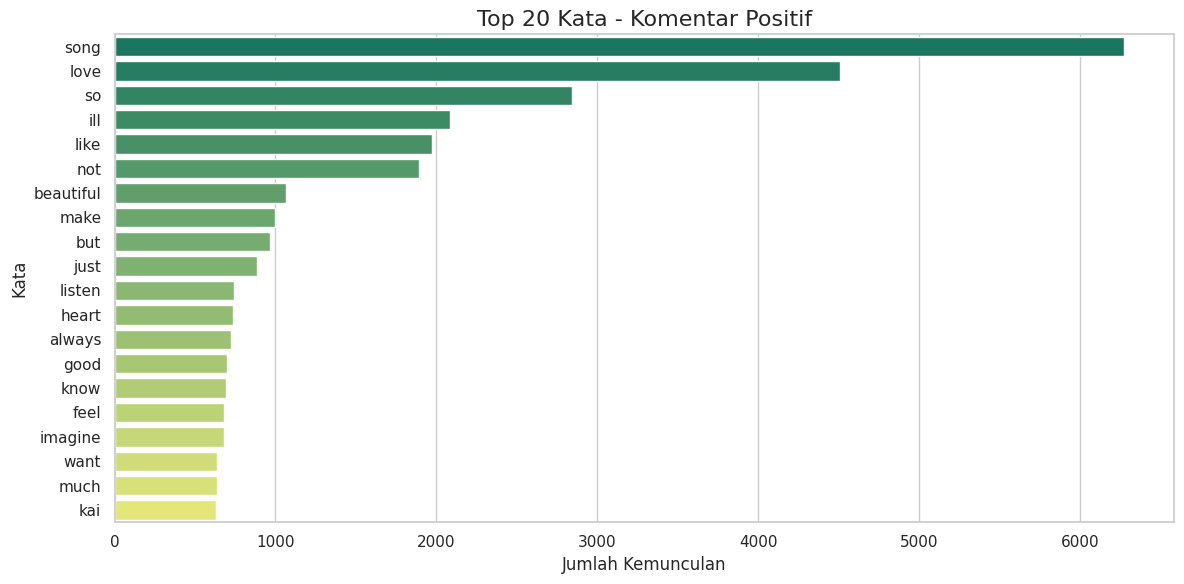

📊 Sentimen Netral


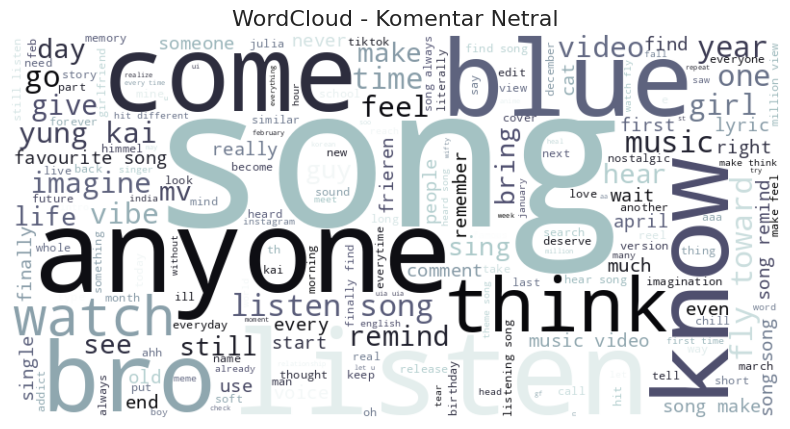

/tmp/ipython-input-38-3546788219.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(top_words), palette=color_map)


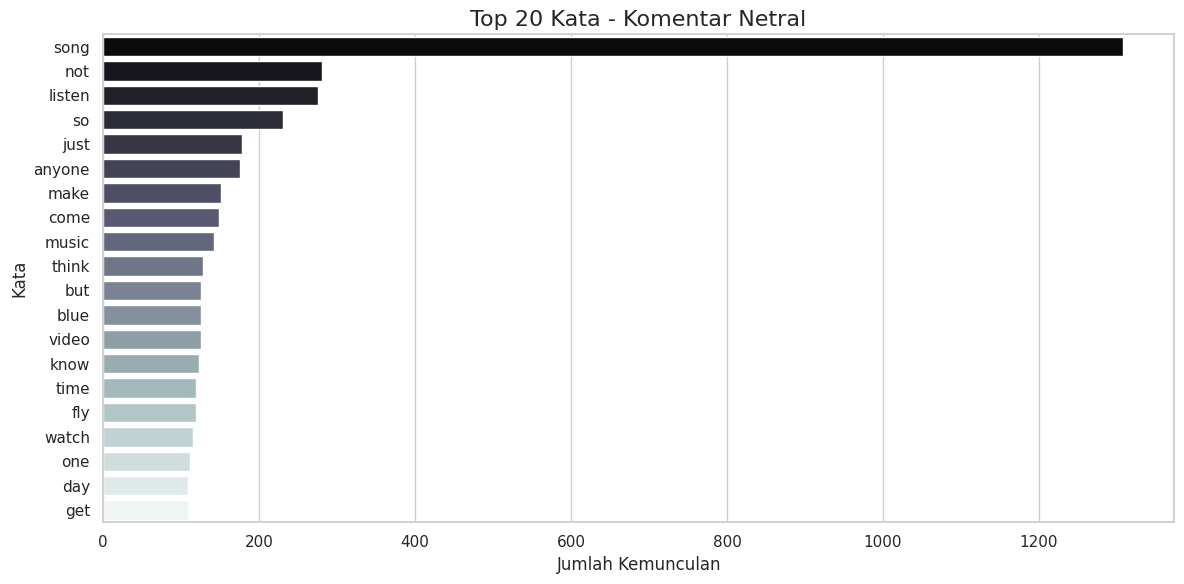

📉 Sentimen Negatif


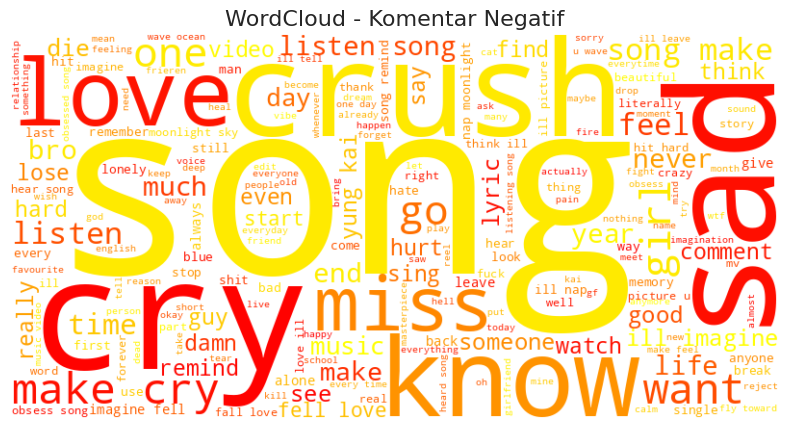

/tmp/ipython-input-38-3546788219.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(top_words), palette=color_map)


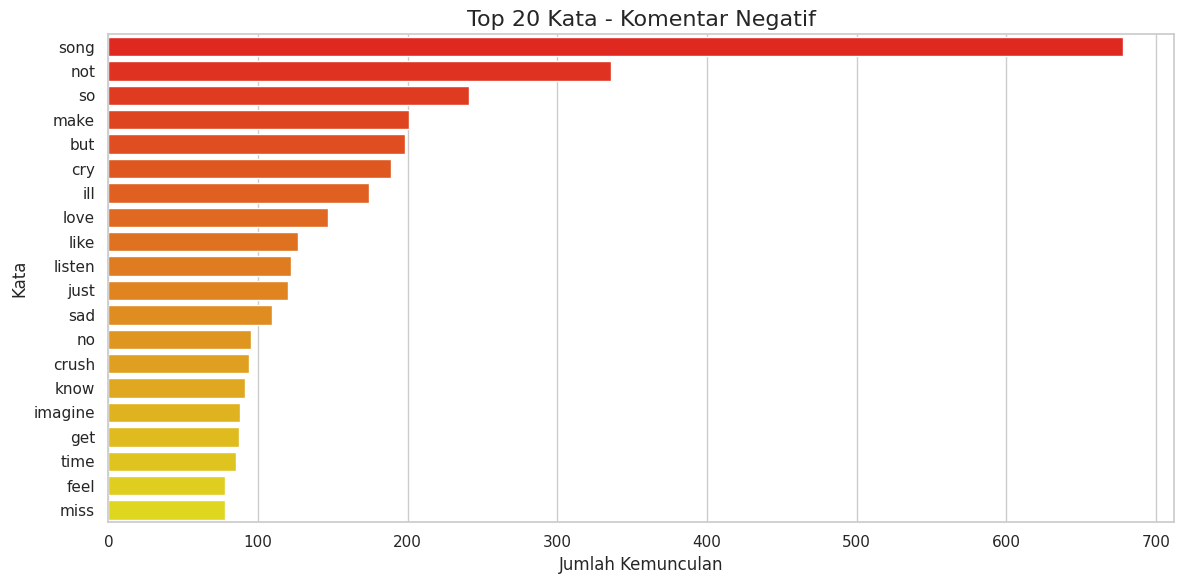

In [ ]:
# Fungsi untuk menghasilkan WordCloud dan Bar Chart untuk satu sentimen
def generate_wordcloud_and_rank(df, sentiment_label, title, color_map):
    # Gabungkan semua teks berdasarkan sentimen
    text = " ".join(df[df['sentiment_vader'] == sentiment_label]['text_akhir'])

    # === WordCloud ===
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap=color_map, max_words=200).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {title}", fontsize=16)
    plt.show()

    # === Rank Kata ===
    words = text.split()
    word_counts = Counter(words)
    ranked_words = word_counts.most_common(20)  # Top 20 kata

    # Pisahkan kata dan jumlahnya
    if ranked_words:
        top_words, counts = zip(*ranked_words)

        # === Bar Chart ===
        plt.figure(figsize=(12, 6))
        sns.barplot(x=list(counts), y=list(top_words), palette=color_map)
        plt.title(f"Top 20 Kata - {title}", fontsize=16)
        plt.xlabel('Jumlah Kemunculan')
        plt.ylabel('Kata')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Tidak ada kata yang cukup untuk dianalisis pada kategori: {title}")

# === Tampilkan untuk setiap sentimen secara terpisah ===
print("📈 Sentimen Positif")
generate_wordcloud_and_rank(clean_df, 'positive', 'Komentar Positif', 'summer')

print("📊 Sentimen Netral")
generate_wordcloud_and_rank(clean_df, 'neutral', 'Komentar Netral', 'bone')

print("📉 Sentimen Negatif")
generate_wordcloud_and_rank(clean_df, 'negative', 'Komentar Negatif', 'autumn')


In [ ]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
clean_df['label'] = label_encoder.fit_transform(clean_df['sentiment_vader'])
num_classes = len(label_encoder.classes_)  # Number of unique classes (positive, neutral, negative)

In [ ]:
from tqdm import tqdm

# === DATA AUGMENTATION WITH RANDOM INSERTION/DELETION/SWAPPING ===
def random_insertion(text, n=1):
    words = text.split()
    for _ in range(n):
        if len(words) > 1:
            insert_pos = random.randint(0, len(words) - 1)
            random_word = random.choice(words)
            words.insert(insert_pos, random_word)
    return ' '.join(words)

def random_deletion(text, p=0.2):
    words = text.split()
    if len(words) <= 1:
        return text
    new_words = []
    for word in words:
        if random.random() > p:
            new_words.append(word)
    if not new_words:
        return words[0]
    return ' '.join(new_words)

def random_swap(text, n=1):
    words = text.split()
    for _ in range(n):
        if len(words) > 1:
            idx1, idx2 = random.sample(range(len(words)), 2)
            words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

def augment_text(text):
    text = random_insertion(text, n=1)
    text = random_deletion(text, p=0.2)
    text = random_swap(text, n=1)
    return text

def augment_data_balanced(df, target_count=None):
    augmented_texts = []
    augmented_labels = []

    label_counts = df['label'].value_counts()
    if target_count is None:
        target_count = label_counts.max()

    print("\n[•] Mulai augmentasi untuk label dengan jumlah < ", target_count)

    for label, count in label_counts.items():
        if count < target_count:
            needed = target_count - count
            samples = df[df['label'] == label]['text_akhir']
            print(f"  - Augmentasi untuk label {label} (butuh {needed} data tambahan)")
            i = 0
            for _ in tqdm(range(needed), desc=f"    Augmenting label {label}"):
                text = samples.iloc[i % len(samples)]
                augmented_texts.append(augment_text(text))
                augmented_labels.append(label)
                i += 1

    augmented_df = pd.DataFrame({'text_akhir': augmented_texts, 'label': augmented_labels})
    return pd.concat([df, augmented_df], ignore_index=True)

print("Distribusi sebelum augmentasi:")
before_counts = clean_df['label'].value_counts().sort_index()

# Jalankan augmentasi sampai jumlah per kelas setara
augmented_df = augment_data_balanced(clean_df)

print("\nDistribusi setelah augmentasi:")
after_counts = augmented_df['label'].value_counts().sort_index()

# Mapping label angka ke teks
label_map = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}

# Header
print(f"\n{'Label':<10} {'Sebelum':>10} {'Sesudah':>10}")
print("-" * 32)

# Baris per label
for label in sorted(label_map.keys()):
    label_name = label_map[label]
    before = before_counts.get(label, 0)
    after = after_counts.get(label, 0)
    print(f"{label_name:<10} {before:>10} {after:>10}")



Distribusi sebelum augmentasi:

[•] Mulai augmentasi untuk label dengan jumlah <  9630
  - Augmentasi untuk label 1 (butuh 6329 data tambahan)


    Augmenting label 1: 100%|██████████| 6329/6329 [00:00<00:00, 79455.46it/s]


  - Augmentasi untuk label 0 (butuh 8171 data tambahan)


    Augmenting label 0: 100%|██████████| 8171/8171 [00:00<00:00, 79504.62it/s]



Distribusi setelah augmentasi:

Label         Sebelum    Sesudah
--------------------------------
Negatif          1459       9630
Netral           3301       9630
Positif          9630       9630


In [ ]:
# === TOKENIZATION AND PADDING ===
max_words = 5000
max_length = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(augmented_df['text_akhir'])
sequences = tokenizer.texts_to_sequences(augmented_df['text_akhir'])
X_padded = pad_sequences(sequences, maxlen=max_length)
y_encoded = to_categorical(augmented_df['label'], num_classes=num_classes)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(augmented_df['label']), y=augmented_df['label'])
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# === CUSTOM EARLY STOPPING CALLBACK (AKURASI >= 0.9 dan LOSS <= 0.05) ===
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.9, target_loss=0.05):
        super(CustomEarlyStopping, self).__init__()
        self.target_accuracy = target_accuracy
        self.target_loss = target_loss

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        train_loss = logs.get('loss')

        if train_acc is not None and train_loss is not None:
            if train_acc >= self.target_accuracy and train_loss <= self.target_loss:
                print(f"\n[✓] Stopping training at epoch {epoch+1} — "
                      f"accuracy ({train_acc:.4f}) >= {self.target_accuracy} "
                      f"and loss ({train_loss:.4f}) <= {self.target_loss}")
                self.model.stop_training = True

In [ ]:
# === LSTM MODEL ===
def build_lstm_model(vocab_size, embedding_dim, max_length, num_classes):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        LSTM(100, return_sequences=False),  # Bisa ditambah Dropout di sini
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Function to train and evaluate LSTM only
def train_evaluate_lstm(X, y, test_size, model_name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=np.argmax(y, axis=1)
    )
    model = build_lstm_model(max_words, 50, max_length, num_classes)

    custom_early_stopping = CustomEarlyStopping(target_accuracy=0.9)

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_split=0.2,
        callbacks=[custom_early_stopping],
        class_weight=class_weight_dict,
        verbose=1
    )

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    print(f"\n=== {model_name} Classification Report ===")
    print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    print(f"Accuracy: {accuracy:.4f}")

    return accuracy, history, model, y_test_classes, y_pred_classes

print("\n=== LSTM Only with 80/20 Split ===")
lstm_acc_80_20, lstm_history_80_20, lstm_model_80_20, y_test_80_20, y_pred_80_20 = train_evaluate_lstm(X_padded, y_encoded, test_size=0.2, model_name="LSTM 80/20")

# Simpan model 80/20
lstm_model_80_20.save("lstm_sentiment_model_80_20.h5")
print("[✓] Model 80/20 berhasil disimpan ke 'lstm_sentiment_model_80_20.h5'")

print("\n=== LSTM Only with 70/30 Split ===")
lstm_acc_70_30, lstm_history_70_30, lstm_model_70_30, y_test_70_30, y_pred_70_30 = train_evaluate_lstm(X_padded, y_encoded, test_size=0.3, model_name="LSTM 70/30")

# Simpan model 70/30
lstm_model_70_30.save("lstm_sentiment_model_70_30.h5")
print("[✓] Model 70/30 berhasil disimpan ke 'lstm_sentiment_model_70_30.h5'")


=== LSTM Only with 80/20 Split ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3921 - loss: 4.5792 - val_accuracy: 0.4806 - val_loss: 3.4974
Epoch 2/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5062 - loss: 3.2071 - val_accuracy: 0.6366 - val_loss: 2.3950
Epoch 3/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6811 - loss: 2.1804 - val_accuracy: 0.7575 - val_loss: 1.6533
Epoch 4/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7877 - loss: 1.5130 - val_accuracy: 0.8179 - val_loss: 1.1864
Epoch 5/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8350 - loss: 1.0939 - val_accuracy: 0.8499 - val_loss: 0.8899
Epoch 6/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8711 - loss: 0.8123 - val_accuracy: 0.8665 - val_loss: 0.7077
Epoch 7/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8864 - loss: 0.6433 - val_accuracy: 0.8732 - val_loss: 0.5849
Epoch 8/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8991 - loss: 0.5229 - val_accuracy: 0.8802 - v


=== LSTM 80/20 Classification Report ===
              precision    recall  f1-score   support

    negative       0.87      0.89      0.88      1926
     neutral       0.92      0.95      0.93      1926
    positive       0.93      0.88      0.91      1926

    accuracy                           0.91      5778
   macro avg       0.91      0.91      0.91      5778
weighted avg       0.91      0.91      0.91      5778

Accuracy: 0.9071
[✓] Model 80/20 berhasil disimpan ke 'lstm_sentiment_model_80_20.h5'

=== LSTM Only with 70/30 Split ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3873 - loss: 4.6511 - val_accuracy: 0.4650 - val_loss: 3.6820
Epoch 2/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5074 - loss: 3.4025 - val_accuracy: 0.6583 - val_loss: 2.6241
Epoch 3/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6630 - loss: 2.4202 - val_accuracy: 0.7436 - val_loss: 1.8871
Epoch 4/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7488 - loss: 1.7595 - val_accuracy: 0.7842 - val_loss: 1.4244
Epoch 5/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7951 - loss: 1.3326 - val_accuracy: 0.8205 - val_loss: 1.1113
Epoch 6/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8283 - loss: 1.0332 - val_accuracy: 0.8334 - val_loss: 0.8792
Epoch 7/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8608 - loss: 0.8070 - val_accuracy: 0.8482 - val_loss: 0.7332
Epoch 8/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8745 - loss: 0.6547 - val_accuracy: 0.8625 - va


=== LSTM 70/30 Classification Report ===
              precision    recall  f1-score   support

    negative       0.87      0.90      0.89      2889
     neutral       0.92      0.93      0.93      2889
    positive       0.93      0.88      0.91      2889

    accuracy                           0.91      8667
   macro avg       0.91      0.91      0.91      8667
weighted avg       0.91      0.91      0.91      8667

Accuracy: 0.9062
[✓] Model 70/30 berhasil disimpan ke 'lstm_sentiment_model_70_30.h5'



=== Comparison of Model Performance ===
        Model  Accuracy
0  LSTM 80/20  0.907061
1  LSTM 70/30  0.906196


/tmp/ipython-input-45-2259015283.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results, palette='Set2')


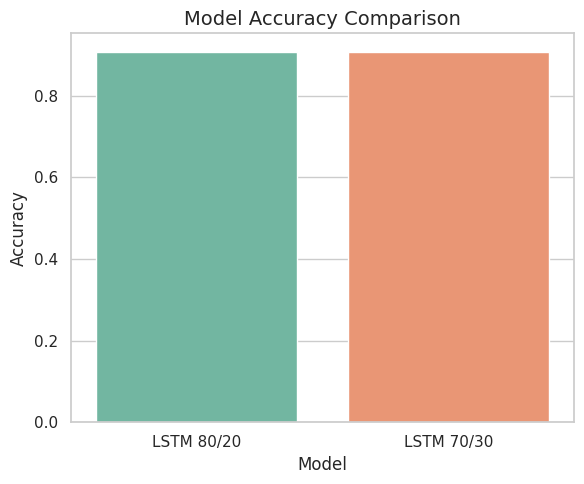

In [ ]:
# === COMPARISON OF RESULTS ===
results = pd.DataFrame({
    'Model': ['LSTM 80/20', 'LSTM 70/30'],
    'Accuracy': [lstm_acc_80_20, lstm_acc_70_30]
})

print("\n=== Comparison of Model Performance ===")
print(results)

# Visualize comparison
plt.figure(figsize=(6, 5))
sns.barplot(x='Model', y='Accuracy', data=results, palette='Set2')
plt.title('Model Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

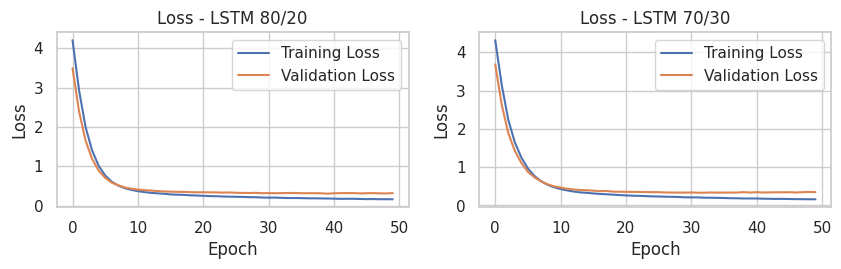

In [ ]:
# === LOSS VISUALIZATION ===
plt.figure(figsize=(10, 5))

# 80/20 Split Loss
plt.subplot(2, 2, 1)
plt.plot(lstm_history_80_20.history['loss'], label='Training Loss')
plt.plot(lstm_history_80_20.history['val_loss'], label='Validation Loss')
plt.title('Loss - LSTM 80/20')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 70/30 Split Loss
plt.subplot(2, 2, 2)
plt.plot(lstm_history_70_30.history['loss'], label='Training Loss')
plt.plot(lstm_history_70_30.history['val_loss'], label='Validation Loss')
plt.title('Loss - LSTM 70/30')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

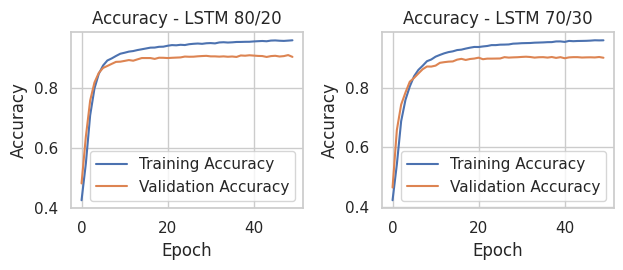

[✓] Model comparison results saved to 'model_comparison_results1.csv'.


In [ ]:
# === ACCURACY PLOT ===
plt.subplot(2, 2, 3)
plt.plot(lstm_history_80_20.history['accuracy'], label='Training Accuracy')
plt.plot(lstm_history_80_20.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy - LSTM 80/20')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(lstm_history_70_30.history['accuracy'], label='Training Accuracy')
plt.plot(lstm_history_70_30.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy - LSTM 70/30')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('loss_accuracy_comparison.png')
plt.show()

# Save results to CSV
results.to_csv('model_comparison_results1.csv', index=False)
print("[✓] Model comparison results saved to 'model_comparison_results1.csv'.")

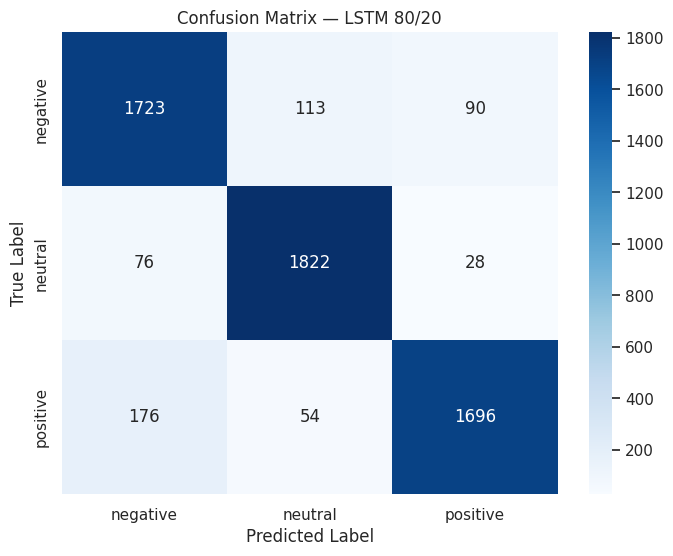

In [ ]:
# Confusion Matrix — LSTM 80/20
cm = confusion_matrix(y_test_80_20, y_pred_80_20)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix — LSTM 80/20')
plt.show()


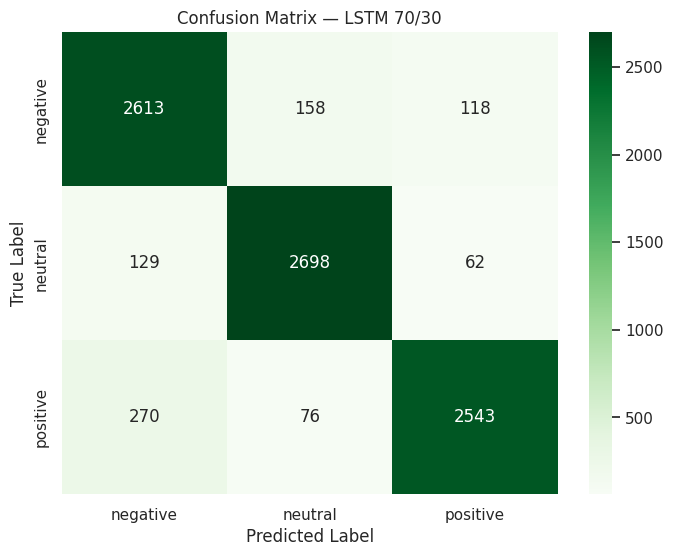

In [ ]:
# Confusion Matrix — LSTM 70/30
cm = confusion_matrix(y_test_70_30, y_pred_70_30)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix — LSTM 70/30')
plt.show()


In [ ]:
# Simpan tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("[✓] Tokenizer berhasil disimpan ke 'tokenizer.pkl'")

# Simpan label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
print("[✓] LabelEncoder berhasil disimpan ke 'label_encoder.pkl'")


[✓] Tokenizer berhasil disimpan ke 'tokenizer.pkl'
[✓] LabelEncoder berhasil disimpan ke 'label_encoder.pkl'


In [ ]:
# Load model dan tools
model = load_model("lstm_sentiment_model_80_20.h5")

with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# === Fungsi preprocessing (pastikan fungsi-fungsi ini sudah kamu definisikan) ===
def preprocess_text_for_inference(text):
    text = cleaningText(text)
    text = casefoldingText(text)
    text = standard_slangwords(text)
    tokens = tokenizingText(text)
    tokens = filteringText(tokens)
    tokens = lemmatizationText(tokens)
    return ' '.join(tokens)

# === Fungsi prediksi sentimen ===
def predict_sentiment(text, model, tokenizer, label_encoder, max_length=100):
    preprocessed_text = preprocess_text_for_inference(text)
    sequence = tokenizer.texts_to_sequences([preprocessed_text])
    padded = pad_sequences(sequence, maxlen=max_length)

    prediction = model.predict(padded)
    predicted_label = np.argmax(prediction, axis=1)[0]
    sentiment = label_encoder.inverse_transform([predicted_label])[0]
    confidence = np.max(prediction)

    print("\n=== HASIL PREDIKSI ===")
    print(f"Teks asli                : {text}")
    print(f"Teks setelah preprocessing: {preprocessed_text}")
    print(f"Sentimen                 : {sentiment}")
    print(f"Confidence               : {confidence:.2f}")

    return sentiment

# === Interaktif: input dari pengguna ===
while True:
    user_input = input("\nMasukkan teks ulasan (atau ketik 'exit' untuk keluar): ")
    if user_input.lower() == 'exit':
        print("Terima kasih! Keluar dari program.")
        break
    predict_sentiment(user_input, model, tokenizer, label_encoder)


Masukkan teks ulasan (atau ketik 'exit' untuk keluar): The song is really entertaining, its was so chill and relaxing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step

=== HASIL PREDIKSI ===
Teks asli                : The song is really entertaining, its was so chill and relaxing
Teks setelah preprocessing: song really entertain so chill relax
Sentimen                 : positive
Confidence               : 1.00

Masukkan teks ulasan (atau ketik 'exit' untuk keluar): The lyrics is so bad, they need to make it better.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

=== HASIL PREDIKSI ===
Teks asli                : The lyrics is so bad, they need to make it better.
Teks setelah preprocessing: lyric so bad need make good
Sentimen                 : negative
Confidence               : 0.91

Masukkan teks ulasan (atau ketik 'exit' untuk keluar): The song has a runtime of approximately 3 minutes and 45 seconds.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

=== HASIL PREDIKSI ===
Teks asli                : The song has 